In [1]:
from torch_DE.geometry.shapes import *
from torch_DE.continuous import DE_Getter
from torch_DE.continuous.Networks import MLP
from torch.optim.lr_scheduler import StepLR
from torch_DE.utils import R3_sampler, Data_handler,Loss_handler,sample_from_tensor
from torch_DE.equations import get_derivatives,get_NavierStokes
from matplotlib import tri

# Lid Driven Cavity

In this tutorial we will look at:
1. How to generate points from boundaries of domains 
2. Difference between Torch DE syntax and setup vs how many others set up PINNs 

The Lid driven Cavity system is defined by the steady state Navier stokes equations. We we will be using the same setup and geometry Nvidia Modulus Lid driven Flow [Example](https://docs.nvidia.com/deeplearning/modulus/modulus-v2209/user_guide/basics/lid_driven_cavity_flow.html)



$$
u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} + \frac{\partial p}{\partial x} - \frac{1}{\text{Re}}(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}) = 0
\\
u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} + \frac{\partial p}{\partial y} - \frac{1}{\text{Re}}(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2}) = 0
$$

<center><img src="https://docscontent.nvidia.com/dims4/default/8d42e19/2147483647/strip/true/crop/308x292+0+0/resize/308x292!/format/webp/quality/90/?url=https%3A%2F%2Fk3-prod-nvidia-docs.s3.us-west-2.amazonaws.com%2Fbrightspot%2Fsphinx%2F00000187-bf1b-d3c6-a7f7-ff7f4e8b0000%2Fdeeplearning%2Fmodulus%2Fmodulus-v2209%2F_images%2Fldc.png"/></center>

Here the top wall has a velocity of $ (u,v)^T = [1,0]^T$ and the other walls are no slip (i.e $u = v = 0$ along all other walls). The Reynolds (Re) number for this example is set to 100. The geometry is a square of length 0.1m x 0.1m

## Geometry

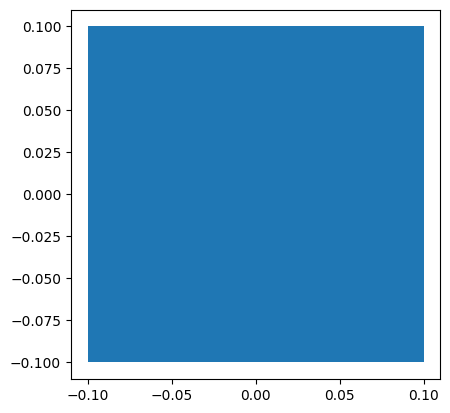

In [2]:
from torch_DE.geometry.shapes import Domain2D,Rectangle
xmin,xmax = (-0.1,0.1)
ymin,ymax = (-0.1,0.1) 
domain = Domain2D(base = Rectangle(((xmin,ymin),(xmax,ymax) ),'corners'))
domain.plot()

In [3]:
sampled_points = domain.generate_points(400_000)


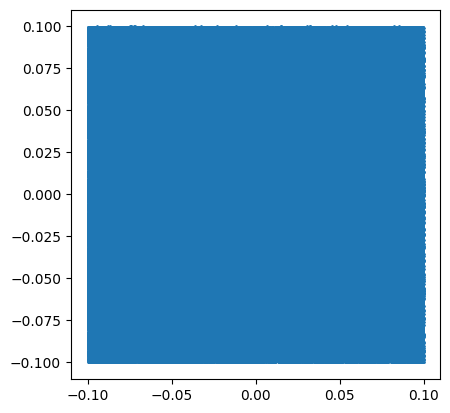

In [4]:
plt.gca().set_aspect('equal')
plt.scatter(sampled_points[:,0],sampled_points[:,1],s=1)

## Generate BC

Torch DE domains automatically define the exterior edges of the base shape. Starting from the left, it moves in an anticlock wise fashion

In [5]:
num_points = 150
boundary_points = domain.generate_boundary_points(num_points=num_points,random = False)

left_wall = boundary_points['exterior_edge_0']
top_wall = boundary_points['exterior_edge_1']
right_wall = boundary_points['exterior_edge_2']
bot_wall = boundary_points['exterior_edge_3']

no_slip = torch.cat([left_wall,right_wall,bot_wall])
no_slip.shape,top_wall.shape

C:\Users\John Su\Downloads\Py_DE\Pytorch_PINNs\src\torch_DE\geometry\shapes.py:200: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.generate_points_from_line(exterior,points_per_line*num_lines,random = random))


(torch.Size([450, 2]), torch.Size([150, 2]))

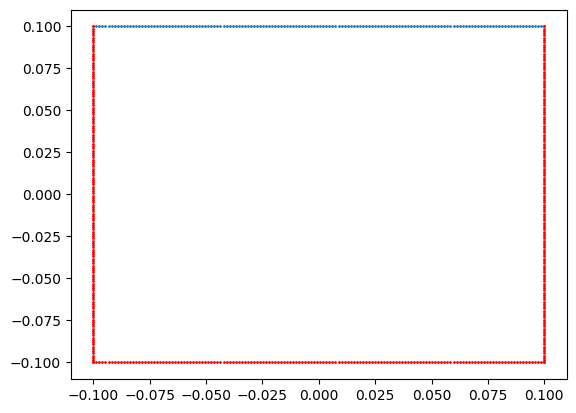

In [6]:
data = Data_handler()
data['collocation points']=sample_from_tensor(2000,t=sampled_points)
data['inlet'] = top_wall
data['no_slip'] = no_slip

plt.scatter(top_wall[:,0],top_wall[:,1],s=1)
plt.scatter(no_slip[:,0],no_slip[:,1],s=1,c = 'r')

### SDF

Torch DE geometry has a built in feature to calculate the signed distance function (SDF) which represents the shortest distance from a point inside the geometry to the boundary. Torch DE kind of brute forces it with the shapely distance function but is sufficient for training PINNs. SDF functions are great way to improve training by using it to spatially weight gradients. This is because high gradients tend to occur near boundaries

c:\Users\John Su\Downloads\Py_DE\env\lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
C:\Users\John Su\Downloads\Py_DE\Pytorch_PINNs\src\torch_DE\utils\GridInterpolator.py:63: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/BucketizationUtils.h:34.)
  idx_right = torch.bucketize(x, p)


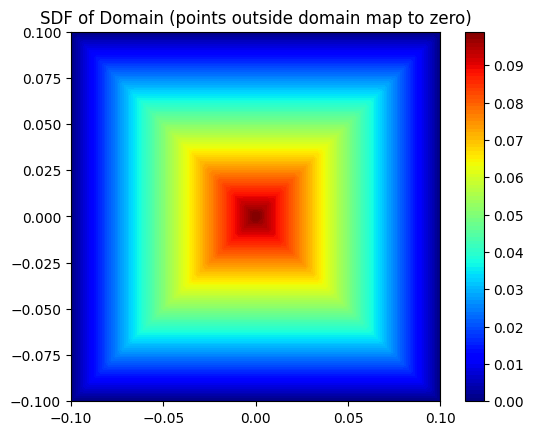

In [7]:
sdf = domain.create_sdf(device = 'cuda')
domain.plot_sdf()

Getting the derivivatives can be cumbersome especially for equations like Navier Stokes. Thankfully, torch DE has a get_derivatives function that can automatically extract the derivatives that are inputs to functions. Like before, torch DE assumes that derivatives are in the form y_x $= \frac{dy}{dx} = y_x$ where y would be the dependent variable and x the independent variable.

In [8]:
import inspect
def Stokes_Flow(u_x,u_xx,u_yy,p_x,v_y,v_xx,v_yy,p_y,Re = 100, **kwargs):
    NS_y =p_y - 1/Re*(v_xx + v_yy)
    return NS_y

def Stokes_Flow_x(u,v,u_x,u_y,u_xx,u_yy,p_x,v_y,v_xx,v_yy,p_y,Re = 100, **kwargs):
    NS_x =u*u_x + v*u_y + p_x - 1/Re*(u_xx + u_yy)
    return NS_x

def Stokes_Flow_y(u,v,u_x,u_y,u_xx,u_yy,p_x,v_y,v_x,v_xx,v_yy,p_y,Re = 100, **kwargs):
    NS_y =u*v_x + v*v_y + p_y - 1/Re*(v_xx + v_yy)
    return NS_y

def incomp(u_x,v_y, **kwargs):
    incomp = u_x + v_y
    return incomp


derivative_names = get_derivatives(['x','y'],['u','v','p'],Stokes_Flow_x,Stokes_Flow_y,incomp,merge = True)
sorted(derivative_names)

['p_x', 'p_y', 'u_x', 'u_xx', 'u_y', 'u_yy', 'v_x', 'v_xx', 'v_y', 'v_yy']

In [13]:
torch.manual_seed(1234)
net = MLP(2,3,50,6)
optimizer = torch.optim.Adam(params = net.parameters(), lr = 1e-3)
LR_sch = StepLR(optimizer,10000,0.9)


sampler = R3_sampler(group = 'collocation points', sampler=domain.generate_points)
PINN = DE_Getter(net)
PINN.set_vars(['x','y'],['u','v','p'])
PINN.set_derivatives(list(derivative_names))
PINN.set_deriv_method('AD')

losses = Loss_handler(data.group_names())
losses.add_boundary('no_slip',{'u':0,
                               'v':0})
losses.add_boundary('inlet',{'u':1,
                               'v':0})

losses.add_residual('collocation points',{'stokes_x':Stokes_Flow_x,
                                          'stokes_y':Stokes_Flow_y, 
                                          'incomp':incomp },weighting=sdf)



In [ ]:

torch.manual_seed(1234)
net1 = MLP(2,3,50,4)
torch.manual_seed(1234)
net2 = MLP(2,3,50,4)

xy = torch.meshgrid(torch.linspace(xmin,xmax,100),torch.linspace(ymin,ymax,100))
x = xy[0].flatten()
y = xy[1].flatten()

for net,ex in zip([net1,net2],['SDF OFF','SDF ON']):
    
    print(f'RUNNING {ex}')
    optimizer = torch.optim.Adam(params = net.parameters(), lr = 1e-3)
    LR_sch = StepLR(optimizer,10000,0.9)
    sampler = R3_sampler(group = 'collocation points',sampler=domain.generate_points)
    PINN = DE_Getter(net)
    PINN.set_vars(['x','y'],['u','v','p'])
    PINN.set_derivatives(list(derivative_names))
    PINN.set_deriv_method('AD')

    losses = Loss_handler(data.group_names())
    losses.add_boundary('no_slip',{'u':0,
                                'v':0})
    losses.add_boundary('inlet',{'u':1,
                                'v':0})
    if ex == 'SDF ON': 
        losses.add_residual('collocation points',{'stokes_x':Stokes_Flow_x,
                                            'stokes_y':Stokes_Flow_y, 
                                            'incomp':incomp },weighting=sdf)
    else:
        losses.add_residual('collocation points',{'stokes_x':Stokes_Flow_x,
                                            'stokes_y':Stokes_Flow_y, 
                                            'incomp':incomp },weighting=1)
        
    net = net.cuda()
    torch.manual_seed(1234)
    for i in range(50_001):
        optimizer.zero_grad()
        data.set_to_device('cuda',to_show= False)
        output = PINN.calculate(data,target_group = 'collocation points')
        loss = losses.calculate(data,output)

        loss.sum().backward()
        optimizer.step()
        LR_sch.step()

        data['collocation points'] = sample_from_tensor(2000,sampled_points)

        if (i % 500) == 0:
            losses.print_losses(i)
            losses.log_loss()

    

# By Hand

In [ ]:
import inspect
def Steady_NS(u,u_x,u_y,u_xx,u_yy,p_x,v,v_x,v_y,v_xx,v_yy,p_y,Re = 600, **kwargs):
    NS_x =u*u_x + v*u_y + p_x - 1/Re*(u_xx + u_yy)
    NS_y = u*v_x + v*v_y + p_y - 1/Re*(v_xx + v_yy)
    incomp = u_x + v_y
    return NS_x,NS_y,incomp

derivative_names = set(inspect.signature(Steady_NS).parameters.keys())
for a in ['kwargs','u','v','Re']:
    derivative_names.remove(a)
derivative_names


In [ ]:


def f(xy):
    x,y = xy[:,0], xy[:,1]
    x.requires_grad_(True)
    y.requires_grad_(True)
    out = net(torch.stack( [x,y],dim = 1))

    u,v,p = out[:,0],out[:,1],out[:,2]

    u_x = torch.autograd.grad(
                u, x,
                grad_outputs=torch.ones_like(u),
                retain_graph=True,
                create_graph=True
            )[0]
    
    u_y = torch.autograd.grad(
                u, y,
                grad_outputs=torch.ones_like(u),
                retain_graph=True,
                create_graph=True
            )[0]
    

    u_xx = torch.autograd.grad(
                u_x, x,
                grad_outputs=torch.ones_like(u_x),
                retain_graph=True,
                create_graph=True
            )[0]
    

    u_yy = torch.autograd.grad(
                    u_y, y,
                    grad_outputs=torch.ones_like(u_y),
                    retain_graph=True,
                    create_graph=True
                )[0]
        

    p_x = torch.autograd.grad(
                p, x,
                grad_outputs=torch.ones_like(p),
                retain_graph=True,
                create_graph=True
            )[0]
    


    v_x = torch.autograd.grad(
                v, x,
                grad_outputs=torch.ones_like(v),
                retain_graph=True,
                create_graph=True
            )[0]
    
    
    v_y = torch.autograd.grad(
                v, y,
                grad_outputs=torch.ones_like(v),
                retain_graph=True,
                create_graph=True
            )[0]
    

    v_xx = torch.autograd.grad(
                v_x, x,
                grad_outputs=torch.ones_like(v_x),
                retain_graph=True,
                create_graph=True
            )[0]
    
    v_yy = torch.autograd.grad(
                    v_y, y,
                    grad_outputs=torch.ones_like(v_y),
                    retain_graph=True,
                    create_graph=True
                )[0]
        

    p_y = torch.autograd.grad(
                p, y,
                grad_outputs=torch.ones_like(p),
                retain_graph=True,
                create_graph=True
            )[0]
    
    return (u,v,p),Steady_NS(u,u_x,u_y,u_xx,u_yy,p_x,v,v_x,v_y,v_xx,v_yy,p_y,Re = 100)

    
